In [199]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from lightgbm import LGBMClassifier
import lightgbm as lgb
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

# Airbnb Dataset

## LGBM Model

In [251]:
model = LGBMClassifier(objective = 'binary', predict_raw_score = True)

feature_dir = "../data/out/airbnb_features.csv"
target_dir = "../data/out/airbnb_target.csv"
X = pd.read_csv(feature_dir, index_col = 0).iloc[:,:244]
columns = X.columns
X.columns = range(X.shape[1])
y = pd.read_csv(target_dir, index_col = 0)

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 42)
model = model.fit(train_X, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [252]:
train_X.columns = columns
test_X.columns = columns

In [253]:
pred_test_y = model.predict(test_X)
accuracy_score(pred_test_y, test_y)

0.679324894514768

In [254]:
pred_y = model.predict(X)
accuracy_score(pred_y, y)

0.9008438818565401

## Global Explanation

### PDP & ICE

In [122]:
from sklearn.inspection import PartialDependenceDisplay

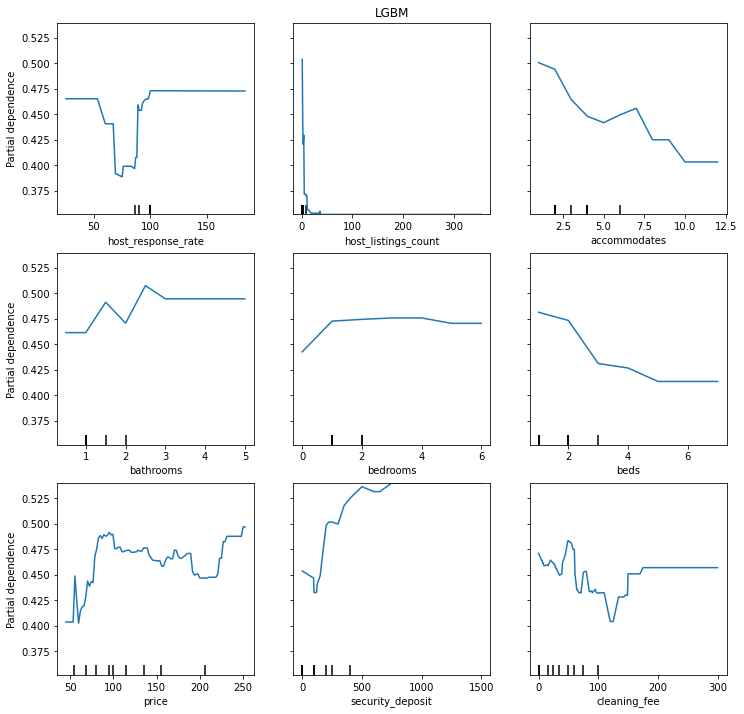

In [123]:
# Partial Dependence Plot that shows dependence between the target function (probability that a given listing has a rating higher than 96) and an input feature of interest
fig, ax = plt.subplots(figsize=(12, 12))
ax.set_title("LGBM")
pdp_airbnb = PartialDependenceDisplay.from_estimator(model, test_X, [x for x in range(9)], ax = ax)

 ### Permutation Feature Importance

In [43]:
from sklearn.inspection import permutation_importance

In [44]:
model.score(test_X, test_y)

0.679324894514768

In [62]:
r = permutation_importance(model, test_X, test_y, n_repeats = 10, random_state=42)

In [63]:
sorted_idx = r.importances_mean.argsort()[::-1][:10][::-1]

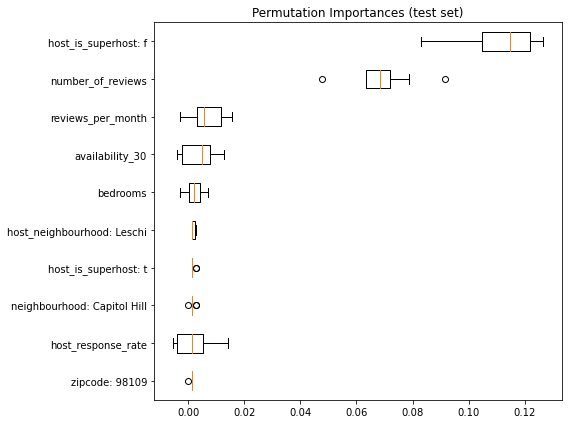

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(
    r.importances[sorted_idx].T, vert=False, labels=test_X.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

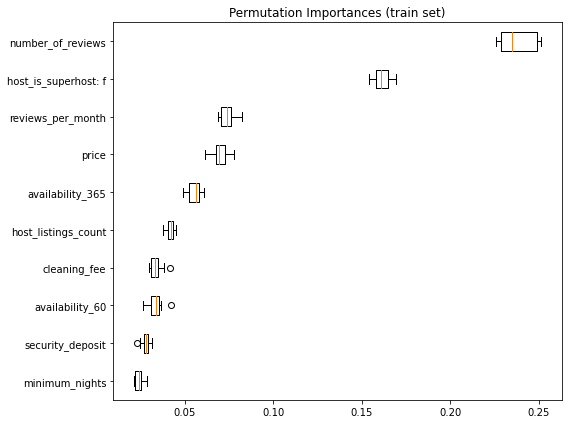

In [65]:
r = permutation_importance(model, train_X, train_y, n_repeats = 10, random_state=42)
sorted_idx = r.importances_mean.argsort()[::-1][:10][::-1]
fig, ax = plt.subplots(figsize=(8, 6))
ax.boxplot(
    r.importances[sorted_idx].T, vert=False, labels=train_X.columns[sorted_idx]
)
ax.set_title("Permutation Importances (train set)")
fig.tight_layout()
plt.show()

## Local Explanation

### SHAP

In [255]:
# the following import is required for access to shap plotting functions and datasets
import shap
import numpy as np

In [256]:
# explain the model's predictions using SHAP
# (same syntax works for LightGBM, CatBoost, scikit-learn, transformers, Spark, etc.)
explainer = shap.Explainer(model)

In [261]:
shap_values = explainer(test_X)[:,:,1][2]

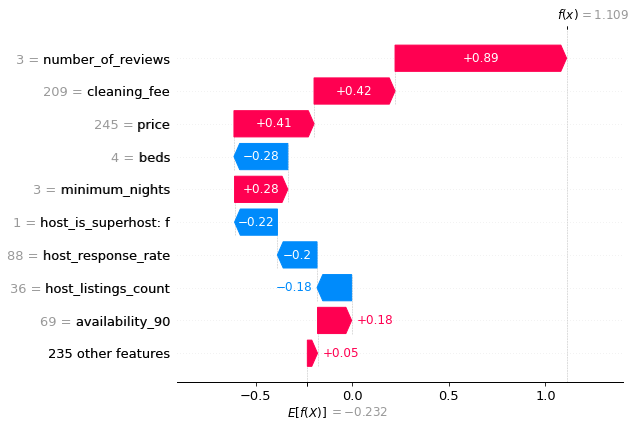

In [262]:
# visualize the third prediction's explanation
shap.plots.waterfall(shap_values)

### LIME

In [268]:
# https://towardsdatascience.com/a-guide-to-interpretable-machine-learning-2-fa3c4489fb53
import lime.lime_tabular

In [271]:
limeexplainer = lime.lime_tabular.LimeTabularExplainer(train_X.values, mode='classification', feature_selection = 'auto', feature_names=columns,class_names = [0,1], 
                                                   kernel_width=None,discretize_continuous=True)

Predicted:  1


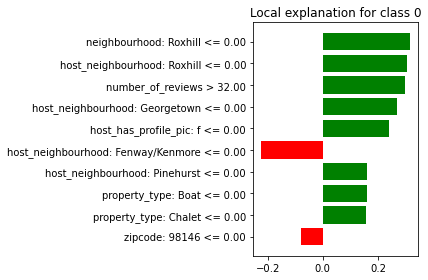

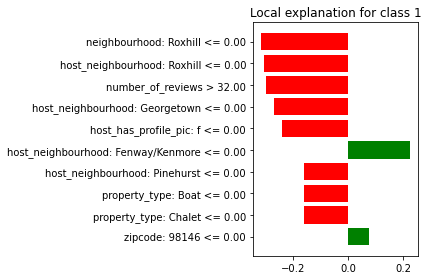

In [273]:
# Now explain a prediction
exp = limeexplainer.explain_instance(test_X.iloc[0], 
                                     model.predict_proba,
                                     labels = [0,1])

print('Predicted: ', pred_test_y[2])

exp.as_pyplot_figure(label = 0)
from matplotlib import pyplot as plt
plt.tight_layout()

exp.as_pyplot_figure(label = 1)
plt.tight_layout()

# Loan Dataset

In [312]:
# some_file.py
import sys
# insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../src/')
import LGBM_Explanations as util
import zipfile

In [286]:
loan_dir = "../data/out/feature_engineered_loan_data.csv.zip"
zf = zipfile.ZipFile(loan_dir)
loan = pd.read_csv(zf.open('feature_engineered_loan_data.csv'))

## LGBM Model

In [287]:
model = LGBMClassifier(objective = 'binary', predict_raw_score = True)

X = loan.drop(['Target','Unnamed: 0'], 1)
columns = X.columns
X.columns = range(X.shape[1])
y = loan[['Target']]

train_X, test_X, train_y, test_y = train_test_split(X, y, random_state = 42)
model = model.fit(train_X, train_y)

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


In [288]:
train_X.columns = columns
test_X.columns = columns

In [289]:
pred_test_y = model.predict(test_X)
accuracy_score(pred_test_y, test_y)

0.9196649236452561

In [290]:
pred_y = model.predict(X)
accuracy_score(pred_y, y)

0.9200711519262725

### PDP

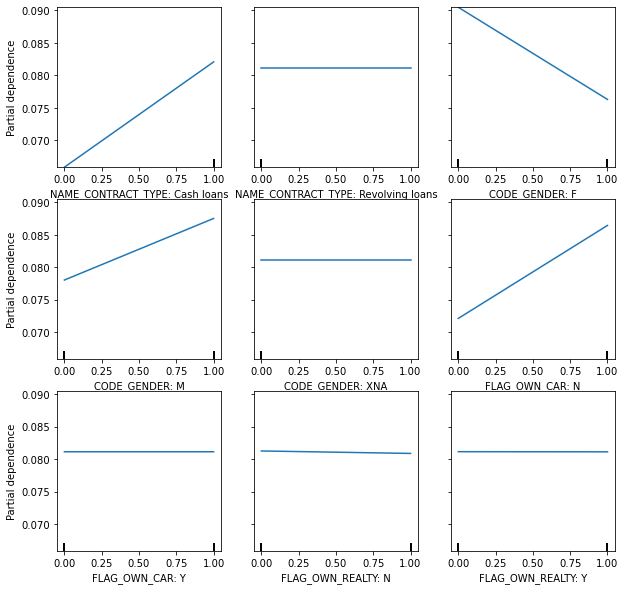

In [292]:
util.PDP(test_X, test_y, model)

### Permutation_Feature_Importance

In [ ]:
util.Permutation_Feature_Importance(test_X, test_y, model, 'Test')

In [ ]:
util.Permutation_Feature_Importance(train_X, train_y, model, 'Train')

### SHAP

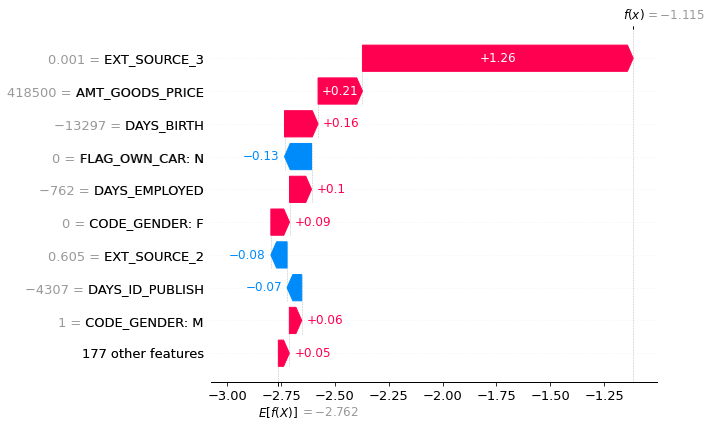

In [311]:
    explainer = shap.Explainer(model)
    shap_values = explainer(test_X)[:,:,1][0]
    # visualize the first prediction's explanation
    shap.plots.waterfall(shap_values)

### LIME

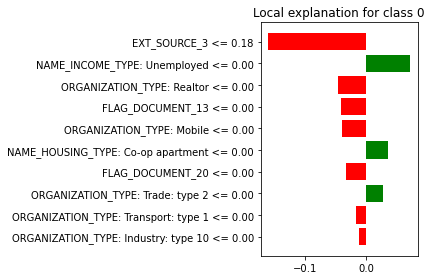

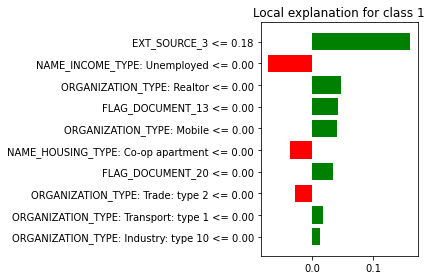

In [319]:
    limeexplainer = lime.lime_tabular.LimeTabularExplainer(test_X.values, mode='classification', feature_selection = 'auto', feature_names=columns,class_names = [0,1],
                                                   kernel_width=None,discretize_continuous=True)
    # Now explain a prediction
    exp = limeexplainer.explain_instance(test_X.iloc[0],
                                     model.predict_proba,
                                     labels = [0,1])


    exp.as_pyplot_figure(label = 0)
    plt.tight_layout()

    exp.as_pyplot_figure(label = 1)
    plt.tight_layout()